# $\S 2.1$ Interpolation Methods of 1D
---

In this lab, I will test three algorithms of solving no-linear equation about their correctness and efficiency, they are('*' is alternative to do): 
- Lagrange interpolation
- Newtonian interpolation
- cubic spline interpolation     
- Aitken interpolation*   
- Hermit interpolation*  
And then use them to solve two problems in instruction book.

## 1. realization of these algorithms 

In [26]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.interpolate as std

In [27]:
def vis(polat, f, x, lim=1, ax=None):
    xx = np.linspace(x[0] - lim, x[-1] + lim, 100)
    y = f(xx)
    p = polat(x, f(x))
    yy = p(xx)
    
    if ax is None:
        _, ax = plt.subplots()
    
    ax.plot(xx, y, label='original')
    ax.plot(xx, yy, label='interpolation', linestyle='--')
    ax.scatter(x, f(x), marker='o', color='r', label='interpolation points')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True)
    ax.set_title(f'use {polat.__name__} interpolation')
    ax.legend()
    ax.tick_params(axis='both', which='both', direction='in')

    if ax is None:
        plt.tick_params(axis='both', which='both', direction='in')
        plt.show()

### 1.1. Lagrange Interpolation 

Formualr of Interpolation:   
given that $n+1$ points $(x_i, y_i),\ i\in\{0, 1, 2, ..., n\}$ on function $f(x)$ and the corresponding $f(x)$ value: $y_0, y_1, ..., y_n$. They follow the order: $x_0<x_1<x_2<...<x_n$. we can interplate it by following function with $n^{th}$ largrange method: 
$$
p_n(x) = \sum_{i=0}^{n} y_i\cdot l_i(x) \\ 
\Rightarrow \sum_{i=0}^{n} y_i \cdot \prod_{j=0, j \ne i}^{n} {x - x_j \over x_i - x_j} \tag{1}
$$

In [28]:
def lagrange(x: np.ndarray, y: np.ndarray):
    n = x.shape[0] - 1

    def ll(k, t):
        f = 1
        for j in range(n + 1): # calcualte l_i
            if j != k:
                f *= (t - x[j]) / (x[k] - x[j]) 

        return f
            
    def larg(t):  # O(k*n^2)
        p = 0
        for i in range(n + 1):
            p += ll(i, t) * y[i]

        return p
    
    return larg

### 1.2. Newtonian Interpolation 

Formualr of Interpolation:   
given that $n+1$ points $(x_i, y_i),\ i\in\{0, 1, 2, ..., n\}$ on function $f(x)$ and their corresponding $f(x)$ value: $y_0, y_1, ..., y_n$. They follow the order: $x_0<x_1<x_2<...<x_n$. we can interplate it by following function with $n^{th}$ Newtonian method: 
$$
p_n(x) = f(x_0) + \sum_{i=1}^{n} f[x_0, x_1,..., x_k] \cdot \omega_k(x) \tag{2}
$$
where $f[x_0, x_1, ..., x_k]$ is $k^{th}$ difference of $f(x)$ on interpolation points. 
it can be defined as: 
$$
f[x_1, ..., x_k] = {f[x_1, ..., x_{k-1}] - f[x_2, ..., x_k] \over x_1 - x_k} , \ f[x_i] = f(x_i) = y_i, i=0, 1, ..., n \tag{3}
$$
to make its calculation more easy, we use a table to assist our computation. (suppose that $n = 4$)

<center>

| $\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ x\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ $| $\ \ \ \ \ \ \ \ \ \ \ \ \ \ f(x)\ \ \ \ \ \ \ \ \ \ \ \ \ \ $| $\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ $| $\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ $ | $\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ $|
| :-------: | :---------: | :---------: | :----------: | :-----------: |    
| $x_0$|$f(x_0)$|||   
|$x_1$|$f(x_1)$|$f[x_0, x_1]$| |    
|$x_2$|$f(x_2)$|$f[x_1, x_2]$|$f[x_0, x_1, x_2]$| |     
|$x_3$|$f(x_3)$|$f[x_2, x_3]$|$f[x_1, x_2, x_3]$|$f[x_0, x_1, x_2, x_3]$|  

**Table 1.** difference table of origin function $f$ on interpolation points $x_0, ..., x_n$
</center>

The final result is the diagonal of this table. And to decrease spatial complexity, we use an arr to replace this table, and a special update method is applied here: we update this table from bottom. 

In [29]:
def newton(x: np.ndarray, y: np.ndarray): 
    n = x.shape[0] - 1
    arr = y.copy()
    for i in range(n):  # t: O(n^2), s: O(n)
        for j in range(n, i, -1):  # up date arr, calcualte diff table
            arr[j] = (arr[j] - arr[j - 1]) / (x[j] - x[j - 1 - i])

    def newtonf(var): # calculate interpolation function, O(k * n)
        p = 0
        w = 1
        for i in range(n + 1):
            p += arr[i] * w
            w *= var - x[i]

        return p
    return newtonf

### 1.3. Cubic spline interpolation 

Given $n+1$ sorted interpolation points: $x_0 < x_1 < ... < x_n$, and their corresponding $f(x)$ value: $y_0, y_1, ..., y_n$. Then we can use a series of cubic polynomial to interpolate $f(x)$ in intervals: $[x_i, x_{i+1}]$, where $i = 0, 1, ..., n-1$. The interpolation polynomial can be written as: 
$$
p(x) = {M_i \over 6h_i}(x-x_{i+1})^3 + {M_{i+1} \over 6h_i}(x_i-x)^3 + ({y_i\over h_i}-{M_i h_i \over 6})(x-x_{i+1}) + ({y_{i+1} \over h_i}-{M_{i+1} h_i \over 6})(x_i-x)
$$
where $M_i=f^{''}(x_i), i = 0, 1, ..., n$. These $M_i$ can be regarded as parameters that can be solved by following method:  
Suppose that $M = (M_1, M_2, ..., M_{n-1})$, we get: 
$$
M = A^{-1}(6\cdot T(2)-b)
$$
where:   
$$
A = 
\begin{bmatrix}
2 & \overline \omega_1  &  \\
\omega_2 & 2 & \overline \omega_2 \\
& \omega_2 & 2 & \overline \omega_2 \\
& \\
 &  &\ddots &\ddots & \ddots\\
& & & \omega_{n-2} & 2 & \overline \omega_{n-2} \\
& & & & \omega_{n-2} & 2 \\
\end{bmatrix}_{(n-1)\times(n-1)}
$$
$$
\omega_i = {h_{i-1} \over h_{i-1} + h_{i}},\ \overline \omega_i = 1-\omega_i,\ where\ i=1, 2, ..., n-1
$$
$$
h_i=x_i-x_{i+1},\ where\ i=0, 1,..., n-1
$$
and: 
$$
b=\begin{bmatrix} 
\omega_1 M_0 \\
0 \\
\vdots \\
0 \\
\overline \omega_{n-1} M_n\\
\end{bmatrix}_{(n-1) \times 1}, 
T(2) = \begin{bmatrix}
f[x_0, x_1, x_2] \\
f[x_1, x_2, x_3] \\
\vdots \\ 
f[x_{n-2}, x_{n-1}, x_n] \\
\end{bmatrix}_{(n-1)\times 1}
$$
why I'm going to call $T(2)$ is that $T(2)$ is the second column of difference table of newton's interpolation. 

In [30]:
def cubic_spline(x: np.ndarray, y: np.ndarray):
    n = x.shape[0] - 1
    h = [x[i] - x[i+1] for i in range(n)]  # len = n
    w = [h[i] / (h[i-1] + h[i]) for i in range(1, n)]  # len = n - 1

    A = np.zeros((n-1, n-1))
    A[0, 0], A[0, 1] = 2, 1 - w[0]
    for i in range(1, n-2):
        A[i, i - 1], A[i , i], A[i, i + 1] = w[i], 2, 1 - w[i]
    A[n-2, n-3], A[n-2, n-2] = w[n-2], 2

    arr = y.copy()  # copy y
    for i in range(2):  # time: O(n), space: O(n)
        for j in range(n, i, -1):  # up date arr, calcualte diff table
            arr[j] = (arr[j] - arr[j - 1]) / (x[j] - x[j - 1 - i])

    arr = np.array(arr)
    arr = arr[2:]

    M = np.linalg.inv(A) @ (6 * arr)  # O(n^3)
    M = np.insert(M, 0, 0)
    M = np.append(M, 0)

    def cubs(t):
        i = np.searchsorted(x, t) - 1 
        if i < 0:
            i = 0
        elif i > n - 1:
            i = n - 1

        P1 = M[i]/(6*h[i])*(t-x[i+1])**3
        P2 = M[i+1]/(6*h[i])*(x[i]-t)**3
        P3 = (y[i]/h[i]-h[i]*M[i]/6)*(t-x[i+1])
        P4 = (y[i+1]/h[i]-h[i]*M[i+1]/6)*(x[i]-t)

        return P1 + P2 + P3 + P4

    cubs = np.vectorize(cubs)
    return cubs


### 1.4. Aitken Interpolation*

Aitken's interpolation is a recursive method used to interpolate a function at a given point using known data points. It builds a triangular table (similar to Newton's divided differences) but focuses on iteratively refining the estimate of the interpolated value.
Pseudocode as following: 

<div style="text-align: center;">
    <img src="../../assets/Aitken&apos;s_Interpolation.png" alt="Description" width="750"/>
</div>



In [31]:
def aitken(x: np.ndarray, y: np.ndarray):
    n = x.shape[0]
    P = np.zeros((n, n))

    for i in range(n):
        P[i, 0] = y[i]

    def aitkenf(t):
        for j in range(1, n):
            for i in range(n - j):
                P[i, j] = ((x[i+j] - t)*P[i][j-1] + (t - x[i]) * P[i+1][j-1]) / (x[i+j] - x[i])

        return P[0][n-1]

    aitkenf = np.vectorize(aitkenf)
    return aitkenf

### 1.5. Hermit Interpolation*

Given a set of data points $ (x_0, y_0) $, $ (x_1, y_1) $, ..., $ (x_n, y_n) $ and their corresponding derivatives $ y'_0 $, $ y'_1 $, ..., $ y'_n $, the Hermite interpolating polynomial $ H(x) $ is constructed such that:

$$
H(x_i) = y_i \quad \text{and} \quad H'(x_i) = y'_i \quad \text{for} \ i = 0, 1, ..., n
$$

The Hermite polynomial can be expressed as:

$$
H(x) = \sum_{i=0}^{n} h_i(x) y_i + \sum_{i=0}^{n} k_i(x) y'_i
$$

Here, $ h_i(x) $ and $ k_i(x) $ are the basis polynomials defined as:

$$
h_i(x) = [1 - 2(x - x_i) \ell'_i(x_i)]\cdot \ell_i^2(x)
$$

$$
k_i(x) = (x - x_i)\cdot \ell_i^2(x)
$$

where $ \ell_i(x) $ is the Lagrange basis polynomial:

$$
\ell_i(x) = \prod_{\substack{0 \leq j \leq n \\ j \neq i}} \frac{x - x_j}{x_i - x_j}
$$

and $ \ell'_i(x_i) $ is the derivative of $ \ell_i(x) $ with respect to $ x $ evaluated at $ x = x_i $.
This formular can be simplified by calculating the $ \ell'_i(x_i) $.
we can get:

$$
H(x) = \sum_{i=0}^n [y_i+y_i'(x-x_i)] \cdot \ell_i^2(x)
$$

In [32]:
def hermite(x, y, dy):
    def hermitef(t):
        n = x.shape[0]
        l = np.ones(n)

        for i in range(n):
            for j in range(n):
                if i != j:
                    l[i] *= (t - x[j]) / (x[i] - x[j])

        return np.sum((y + dy*(t - x))*l**2)

    hermitef = np.vectorize(hermitef)
    return hermitef

## 2. Expriments

### 2.1. Experiment 1: Correctness

This experiment applies four interpolation methods—Lagrange interpolation, Newton interpolation, Aitken interpolation, and cubic spline interpolation—to the function $f(x) = x^2 + 30\sin(x)$ over the interval $[-4, 4]$, visualizing the results in a 2x2 subplot layout. The experiment aims to compare and analyze the performance of each interpolation method in handling this nonlinear function, with a focus on the smoothness and accuracy of the interpolated curves.

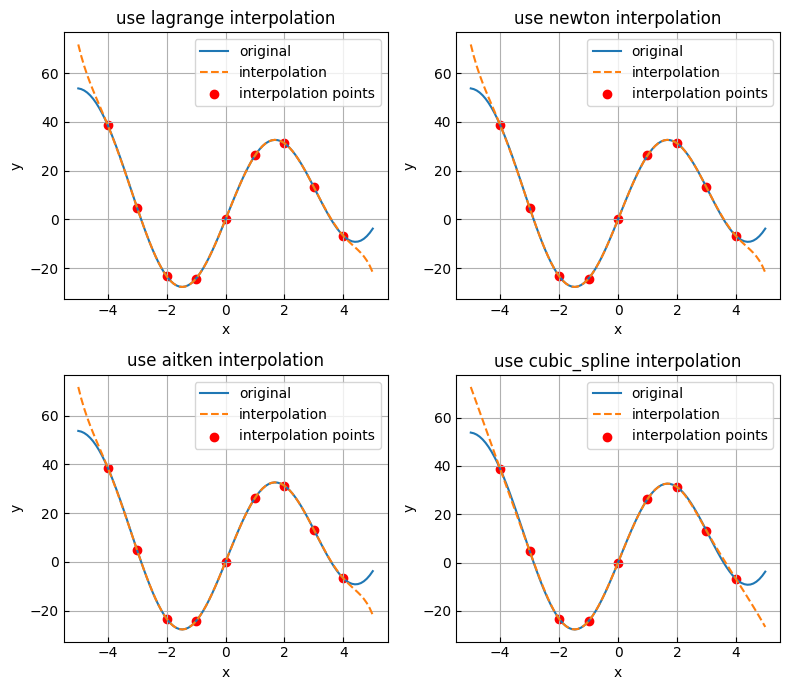

In [33]:
x = np.arange(-4, 5)
f = lambda x: x**2 + 30*np.sin(x)

polat_methods = [lagrange, newton, aitken, cubic_spline]
fig, axs = plt.subplots(2, 2, figsize=(8, 7))

for i, polat in enumerate(polat_methods):
    vis(polat, f, x, 1, ax=axs[i//2, i%2])

plt.tight_layout()
plt.show()

### 2.2. Experiment 2: Runge's phenomenon

This experiment aims to demonstrate the benefits of cubic spline interpolation in mitigating Runge's phenomenon. The function $f(x) = \frac{1}{25x^2 + 1}$, known for exhibiting Runge's phenomenon with high-degree polynomial interpolations, is evaluated over the interval $[-1, 1]$ using 11 evenly spaced points. Four interpolation methods—Lagrange interpolation, Newton interpolation, Aitken interpolation, and cubic spline interpolation—are applied to the function. The results are visualized in a 2x2 subplot layout to compare the performance of each method, particularly focusing on the smoothness and accuracy of cubic spline interpolation in reducing the oscillatory behavior typically seen in Lagrange and Newton interpolations.

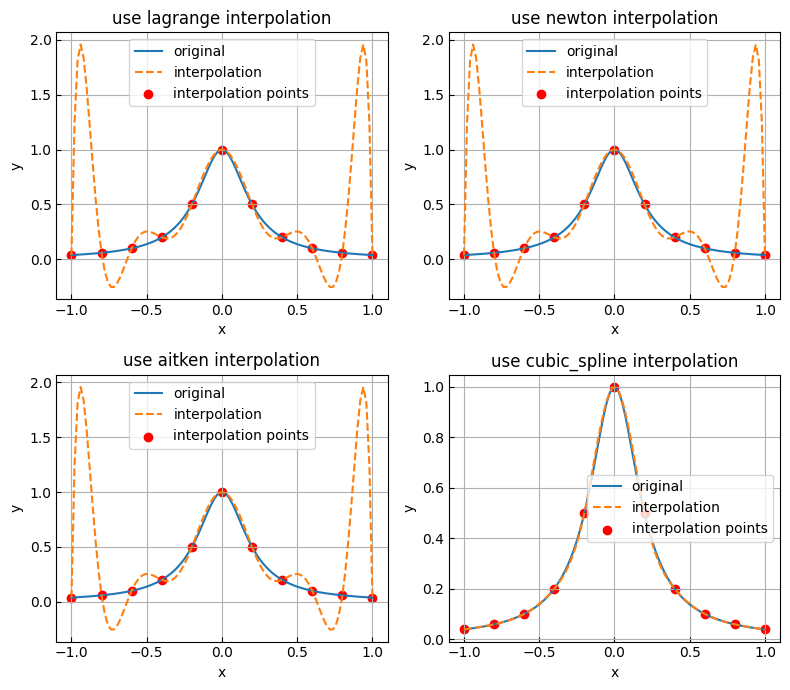

In [34]:
x = np.linspace(-1, 1, 11)
f = lambda x: 1 / (25 * x**2 + 1)

polat_methods = [lagrange, newton, aitken, cubic_spline]
fig, axs = plt.subplots(2, 2, figsize=(8, 7))

for i, polat in enumerate(polat_methods):
    vis(polat, f, x, lim=0, ax=axs[i//2, i%2])

plt.tight_layout()
plt.show()

## 3. Excercises

### 3.1. problem 1

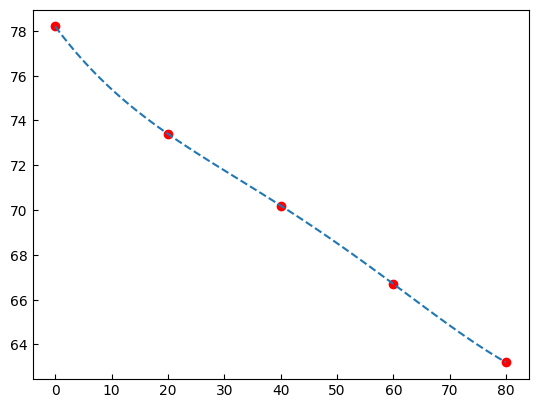

In [35]:
x = np.array([0, 20, 40, 60, 80])
y = np.array([78.2, 73.4, 70.2, 66.7, 63.2])

p = lagrange(x, y)
xx = np.linspace(0, 80, 100)

plt.plot(xx, p(xx), label='lagrange', linestyle='--')
plt.scatter(x, y, label='data', marker='o', color='r')
plt.tick_params(axis='both', which='both', direction='in')
plt.show()



## 3.2. problem 2

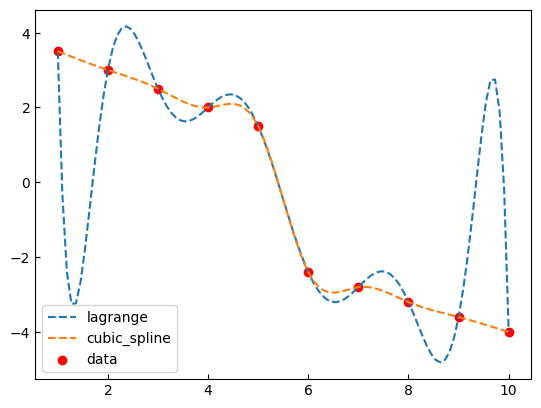

In [36]:
x = np.arange(1, 11)
y = np.array([3.5, 3.0, 2.5, 2.0, 1.5, -2.4, -2.8, -3.2, -3.6, -4.0])

p1 = lagrange(x, y)
p3 = cubic_spline(x, y)

xx = np.linspace(1, 10, 100)

plt.plot(xx, p1(xx), label='lagrange', linestyle='--')
plt.plot(xx, p3(xx), label='cubic_spline', linestyle='--')
plt.scatter(x, y, label='data', marker='o', color='r')
plt.legend()
plt.tick_params(axis='both', which='both', direction='in')
plt.show()